In [1]:
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
indices = np.where(y_train == 4)[0]
sample_index = indices[0]
sample_image = x_train[sample_index]
sample_image=sample_image/255.0
sample_image=sample_image.reshape( 1, 28, 28)

In [3]:
sample_image.shape

(1, 28, 28)

In [4]:
class Conv2D:
    def __init__(self, num_filters, filter_size):
        self.num_filters = num_filters
        self.filter_size = filter_size
        self.filters = np.random.randn(num_filters, 1, filter_size, filter_size) / 9
        self.bias = np.zeros((num_filters, 1))

    def iterate_regions(self, image):
        h, w = image.shape
        for i in range(h - self.filter_size + 1):
            for j in range(w - self.filter_size + 1):
                region = image[i:(i + self.filter_size), j:(j + self.filter_size)]
                yield i, j, region

    def forward(self, input):
        self.last_input = input
        h, w = input.shape[1:]
        output = np.zeros((self.num_filters, h - self.filter_size + 1, w - self.filter_size + 1))
        for f in range(self.num_filters):
            for i, j, region in self.iterate_regions(input[0]):
                output[f, i, j] = np.sum(region * self.filters[f, 0]) + self.bias[f].item()
        return output

    def backward(self, d_L_d_out, learn_rate):
        d_L_d_filters = np.zeros(self.filters.shape)
        d_L_d_bias = np.zeros(self.bias.shape)
        for f in range(self.num_filters):
            for i, j, region in self.iterate_regions(self.last_input[0]):
                d_L_d_filters[f, 0] += d_L_d_out[f, i, j] * region
                d_L_d_bias[f] += d_L_d_out[f, i, j]
        self.filters -= learn_rate * d_L_d_filters
        self.bias -= learn_rate * d_L_d_bias
        return None

In [5]:
class ReLU:
    def forward(self, input):
        self.last_input = input
        return np.maximum(0, input)
    def backward(self, d_L_d_out):
        d_input = d_L_d_out.copy()
        d_input[self.last_input <= 0] = 0
        return d_input

In [6]:
class MaxPool2:
    def iterate_regions(self, image):
        h, w = image.shape
        new_h, new_w = h // 2, w // 2
        for i in range(new_h):
            for j in range(new_w):
                region = image[i*2:i*2+2, j*2:j*2+2]
                yield i, j, region

    def forward(self, input):
        self.last_input = input
        d, h, w = input.shape
        output = np.zeros((d, h//2, w//2))
        self.max_indices = np.zeros_like(input, dtype=bool)
        for c in range(d):
            for i, j, region in self.iterate_regions(input[c]):
                max_val = np.max(region)
                output[c, i, j] = max_val
                max_pos = np.unravel_index(np.argmax(region), region.shape)
                self.max_indices[c, i*2 + max_pos[0], j*2 + max_pos[1]] = True
        return output

    def backward(self, d_L_d_out):
        d_input = np.zeros_like(self.last_input)
        for c in range(d_L_d_out.shape[0]):
            for i in range(d_L_d_out.shape[1]):
                for j in range(d_L_d_out.shape[2]):
                    max_idx = self.max_indices[c, i*2:i*2+2, j*2:j*2+2]
                    d_input[c, i*2:i*2+2, j*2:j*2+2] = d_L_d_out[c, i, j] * max_idx
        return d_input

In [7]:
class Dense:
    def __init__(self, input_len, output_len):
        self.weights = np.random.randn(input_len, output_len) / input_len
        self.biases = np.zeros(output_len)

    def forward(self, input):
        self.last_input_shape = input.shape
        input = input.flatten()
        self.last_input = input
        return np.dot(input, self.weights) + self.biases

    def backward(self, d_L_d_out, learn_rate):
        d_L_d_w = np.outer(self.last_input, d_L_d_out)
        d_L_d_input = np.dot(d_L_d_out, self.weights.T)
        self.weights -= learn_rate * d_L_d_w
        self.biases -= learn_rate * d_L_d_out
        return d_L_d_input.reshape(self.last_input_shape)

In [8]:
def softmax(x):
    exps = np.exp(x - np.max(x))
    return exps / np.sum(exps)

def cross_entropy(pred, label):
    return -np.sum(label * np.log(pred + 1e-9))


In [9]:
display_image=np.squeeze(sample_image)

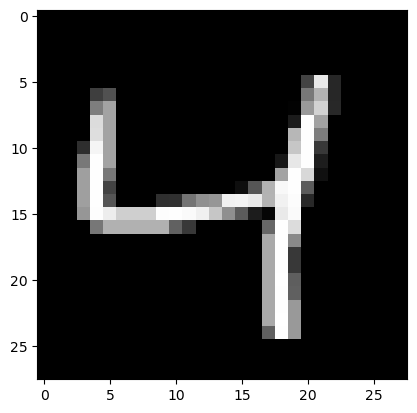

In [10]:
import matplotlib.pyplot as plt
plt.imshow(display_image, cmap="gray")
plt.show()

In [11]:
conv = Conv2D(8, 3)
relu = ReLU()
pool = MaxPool2()
dense = Dense(13*13*8, 10)

In [12]:
def forward(image, label):
    out = conv.forward(image)
    out = relu.forward(out)
    out = pool.forward(out)
    out = dense.forward(out)
    probs = softmax(out)
    loss = cross_entropy(probs, label)
    return probs, loss

def prediction(image,output):
    pred,l=forward(image, output)

    for i in range(len(pred)):
        if pred[i]>0.5:
            return i
    return -1

In [13]:
sample_image.shape[1:]

(28, 28)

In [14]:
out1 = conv.forward(sample_image)

In [15]:
out1.shape

(8, 26, 26)

In [16]:
sample_image.shape

(1, 28, 28)

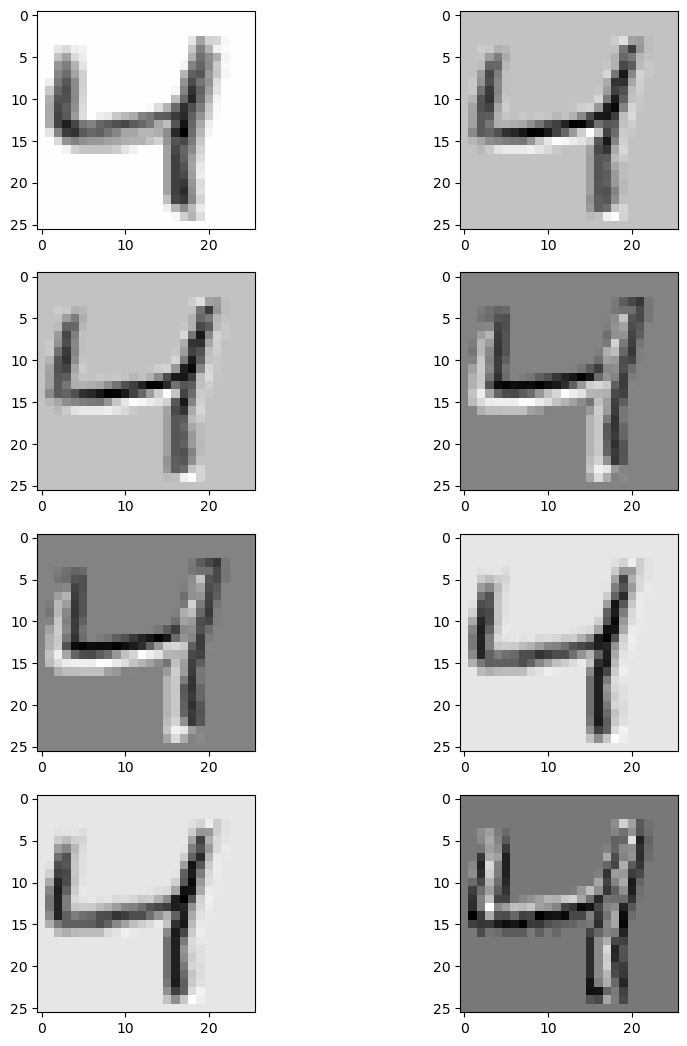

In [17]:
fig, axs = plt.subplots(4, 2, figsize=(10, 13))
for i, ax in enumerate(axs):
    ax[0].imshow(out1[i], cmap='gray')
    ax[1].imshow(out1[i+1], cmap='gray')

In [18]:
relu_out1 = relu.forward(out1)

In [19]:
relu_out1.shape

(8, 26, 26)

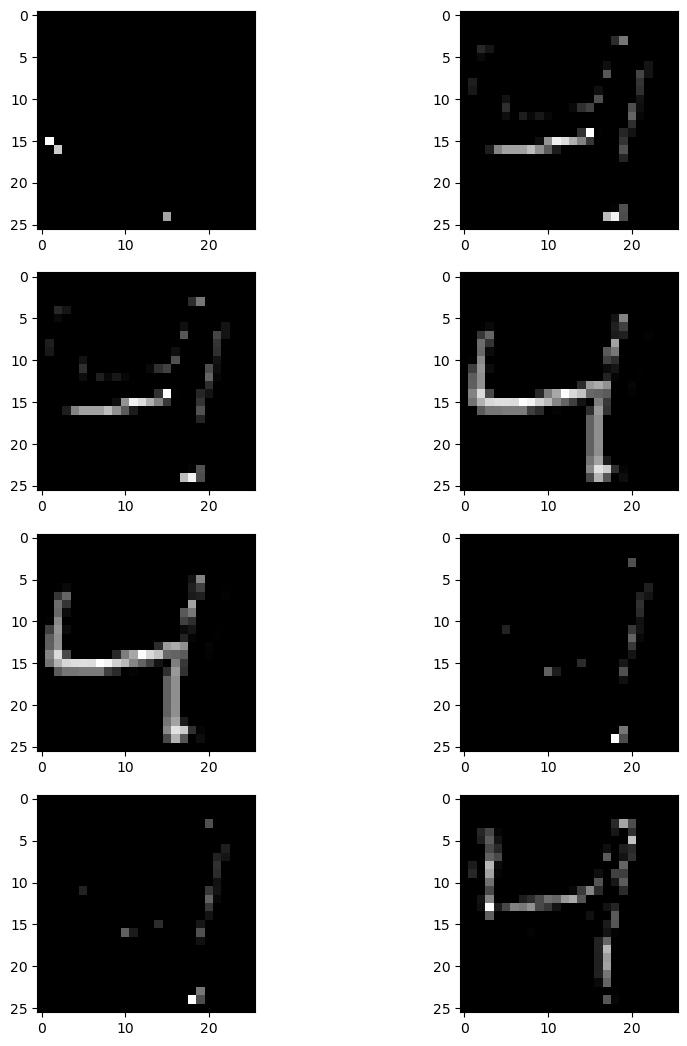

In [20]:
fig, axs = plt.subplots(4, 2, figsize=(10, 13))
for i, ax in enumerate(axs):
    ax[0].imshow(relu_out1[i], cmap='gray')
    ax[1].imshow(relu_out1[i+1], cmap='gray')

In [21]:
pool_out1 = pool.forward(relu_out1)

In [22]:
pool_out1.shape

(8, 13, 13)

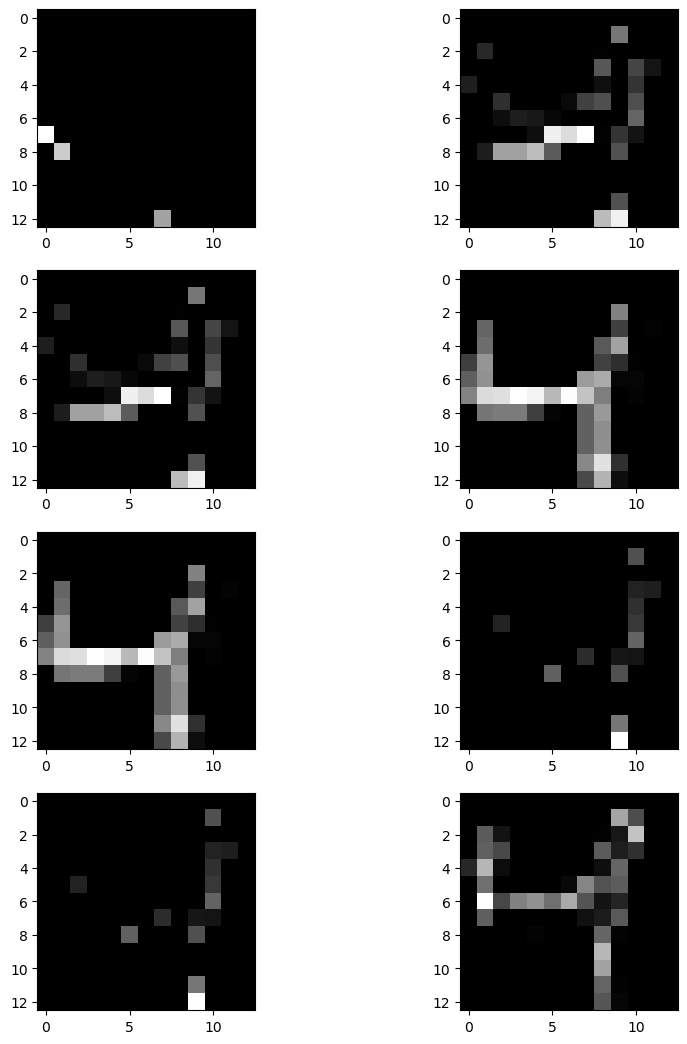

In [23]:
fig, axs = plt.subplots(4, 2, figsize=(10, 13))
for i, ax in enumerate(axs):
    ax[0].imshow(pool_out1[i], cmap='gray')
    ax[1].imshow(pool_out1[i+1], cmap='gray')

In [24]:
d1_out1 = dense.forward(pool_out1)

In [25]:
d1_out1.shape

(10,)

In [26]:
d1_out1

array([ 0.00167234,  0.00445967, -0.00435627, -0.00384939,  0.00047399,
        0.0005892 ,  0.00180984,  0.00044632, -0.00021052,  0.00181881])

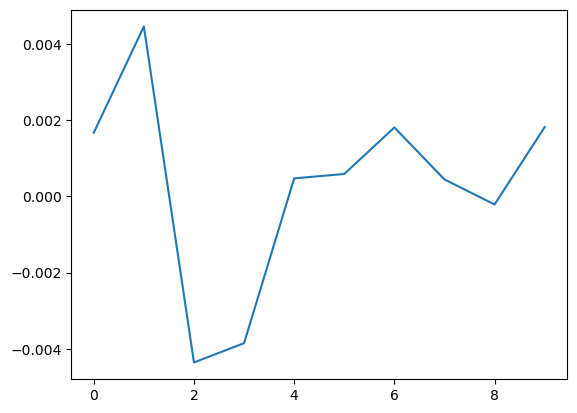

In [27]:
plt.plot(d1_out1)
plt.show()

In [28]:
soft_out1 = softmax(d1_out1)

In [29]:
soft_out1

array([0.10013847, 0.10041798, 0.09953659, 0.09958706, 0.10001855,
       0.10003007, 0.10015224, 0.10001578, 0.09995011, 0.10015314])

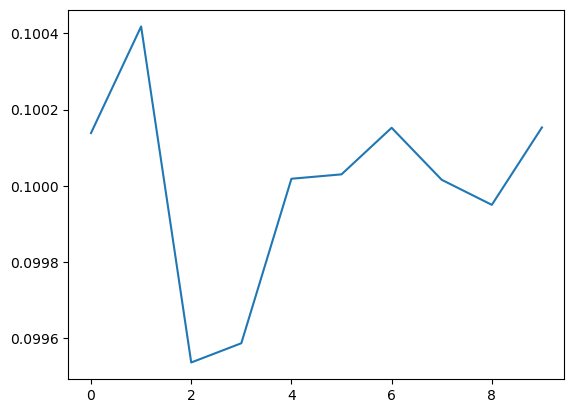

In [30]:
plt.plot(soft_out1)
plt.show()

In [31]:
output = to_categorical(4, 10)

In [32]:
output

array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.], dtype=float32)

In [33]:
loss = cross_entropy(soft_out1, output)

In [34]:
loss

2.3023996478183375

In [35]:
gradient1 = soft_out1 - output

In [36]:
gradient1

array([ 0.10013847,  0.10041798,  0.09953659,  0.09958706, -0.89998145,
        0.10003007,  0.10015224,  0.10001578,  0.09995011,  0.10015314])

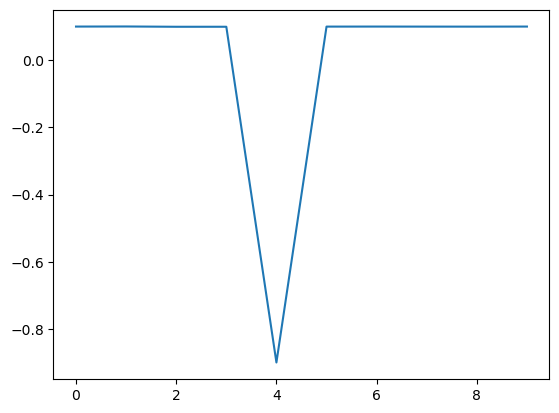

In [37]:
plt.plot(gradient1)
plt.show()

In [38]:
grad_back1 = dense.backward(gradient1, 0.04)

In [39]:
grad_back1

array([[[-2.45222530e-04, -1.22579182e-03, -1.08254870e-03, ...,
         -6.60350104e-05, -2.44609471e-04, -7.04017866e-04],
        [-2.00309806e-04, -3.39331096e-04, -2.31086309e-04, ...,
          1.75598663e-04, -4.88412902e-04, -1.19810237e-03],
        [ 2.71807374e-04, -5.56863600e-04,  5.67446589e-04, ...,
         -7.08243356e-04,  7.90491142e-04, -7.89532018e-04],
        ...,
        [-7.54660771e-04, -3.14229996e-05,  5.56267006e-04, ...,
         -1.00522951e-03,  1.20083121e-03,  3.35693586e-04],
        [ 5.54198256e-04, -2.31054270e-04, -3.83014111e-04, ...,
          2.90620202e-06,  9.06649628e-04,  2.95855482e-04],
        [ 6.86499699e-04, -9.34634505e-04,  3.86234023e-04, ...,
          1.05254722e-03,  7.16671468e-05,  1.92931547e-04]],

       [[-6.17452524e-04,  6.78185101e-04, -3.72173709e-05, ...,
          1.81321473e-04, -9.66419409e-04, -7.96311119e-05],
        [-1.15952405e-03,  1.51945696e-04,  4.95934909e-04, ...,
          1.10400660e-04, -4.47807550e

In [40]:
grad_back1.shape

(8, 13, 13)

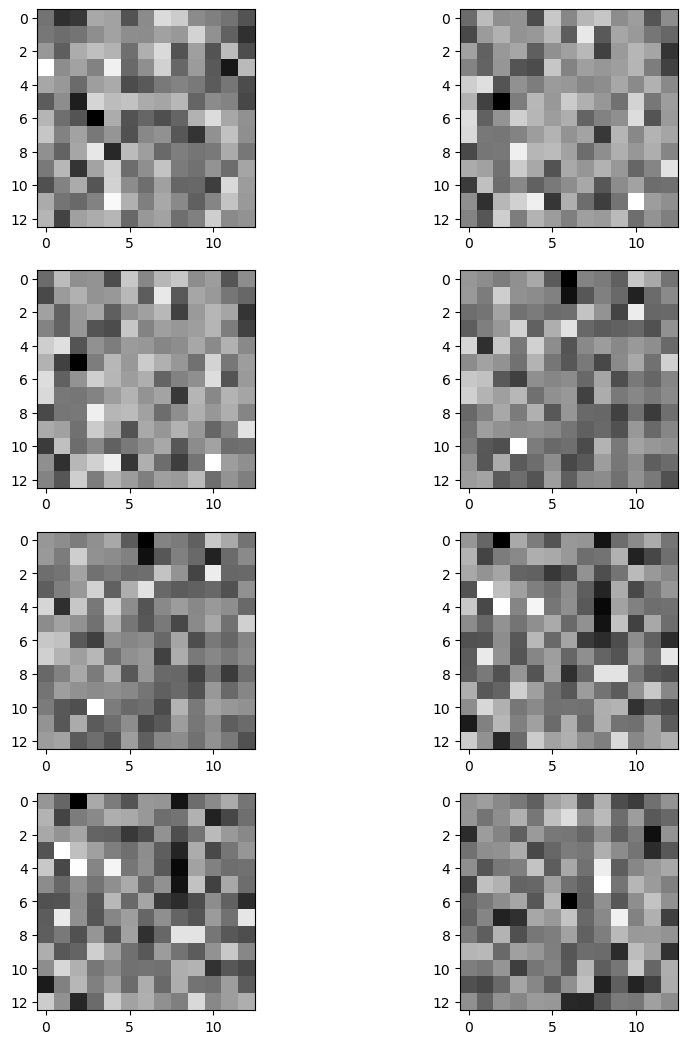

In [41]:
fig, axs = plt.subplots(4, 2, figsize=(10, 13))
for i, ax in enumerate(axs):
    ax[0].imshow(grad_back1[i], cmap='gray')
    ax[1].imshow(grad_back1[i+1], cmap='gray')

In [42]:
grad_back1 = pool.backward(grad_back1)

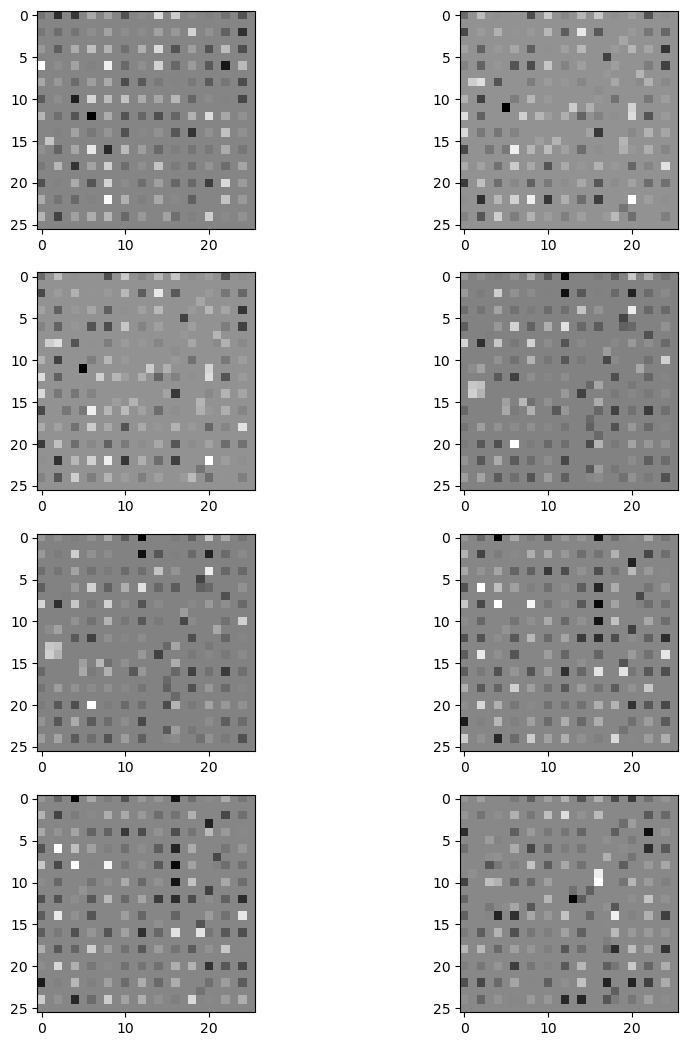

In [43]:
fig, axs = plt.subplots(4, 2, figsize=(10, 13))
for i, ax in enumerate(axs):
    ax[0].imshow(grad_back1[i], cmap='gray')
    ax[1].imshow(grad_back1[i+1], cmap='gray')

In [44]:
grad_back1 = relu.backward(grad_back1)

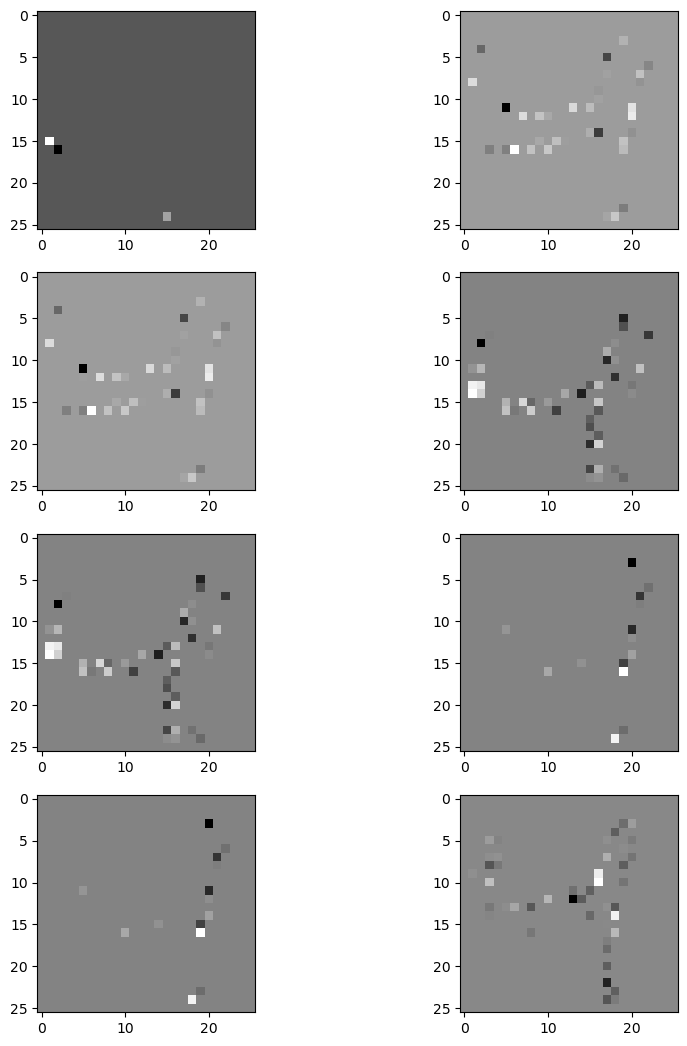

In [45]:
fig, axs = plt.subplots(4, 2, figsize=(10, 13))
for i, ax in enumerate(axs):
    ax[0].imshow(grad_back1[i], cmap='gray')
    ax[1].imshow(grad_back1[i+1], cmap='gray')

In [46]:
conv.backward(grad_back1, 0.04)

In [47]:
prediction(sample_image,output)

-1

In [48]:
sample_image.shape

(1, 28, 28)

In [49]:
out2 = conv.forward(sample_image)

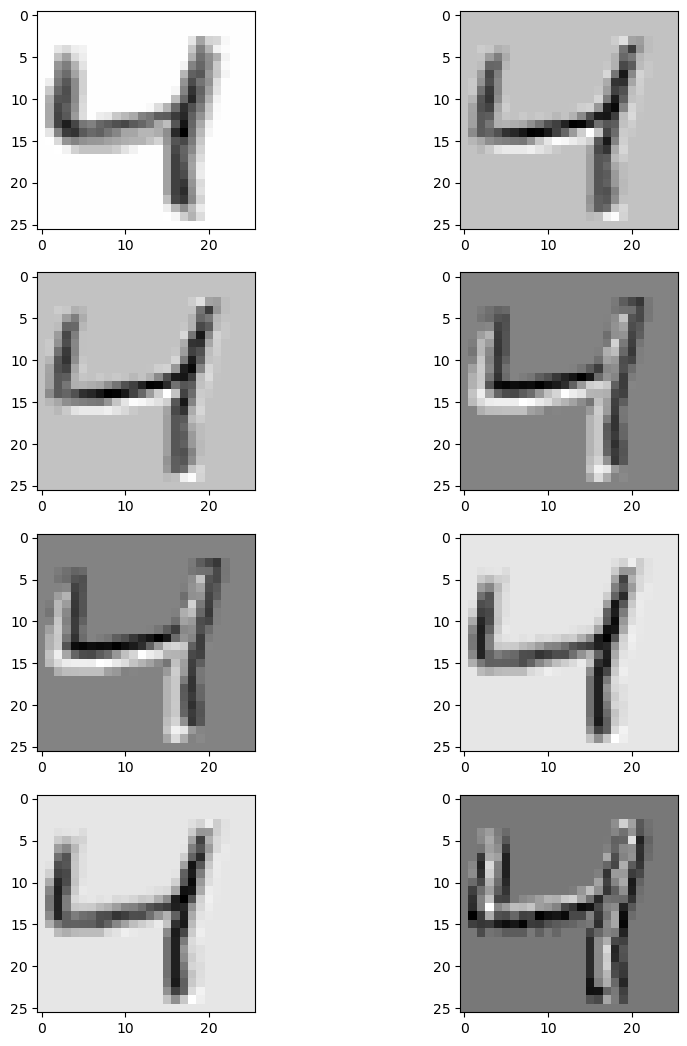

In [50]:
fig, axs = plt.subplots(4, 2, figsize=(10, 13))
for i, ax in enumerate(axs):
    ax[0].imshow(out2[i], cmap='gray')
    ax[1].imshow(out2[i+1], cmap='gray')

In [51]:
relu_out2 = relu.forward(out2)

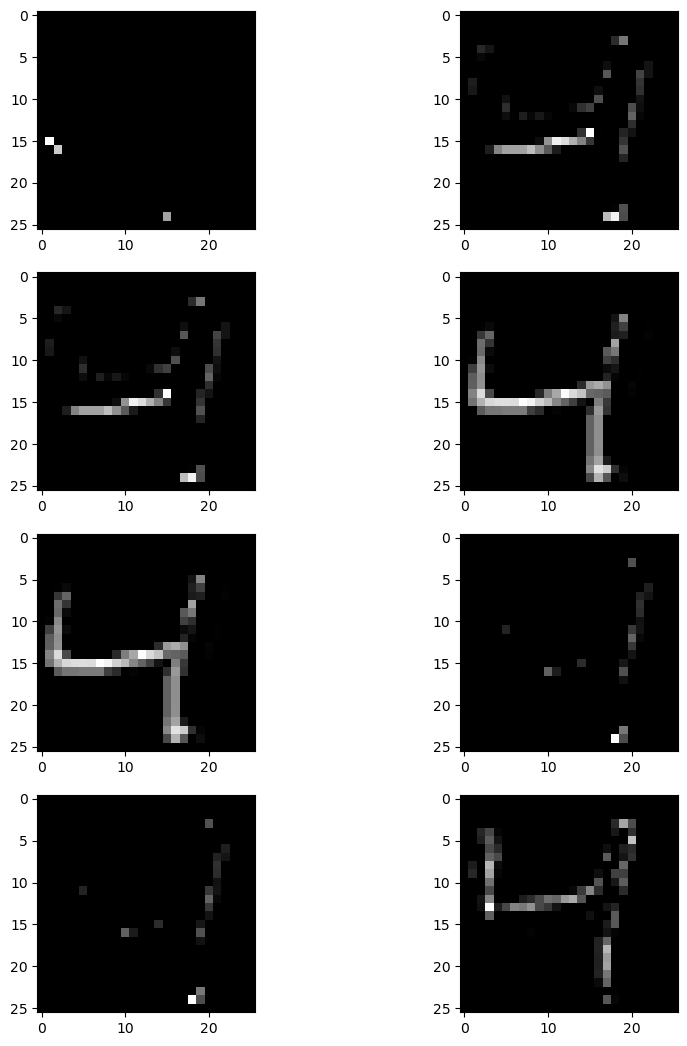

In [52]:
fig, axs = plt.subplots(4, 2, figsize=(10, 13))
for i, ax in enumerate(axs):
    ax[0].imshow(relu_out2[i], cmap='gray')
    ax[1].imshow(relu_out2[i+1], cmap='gray')

In [53]:
pool_out2 = pool.forward(relu_out2)

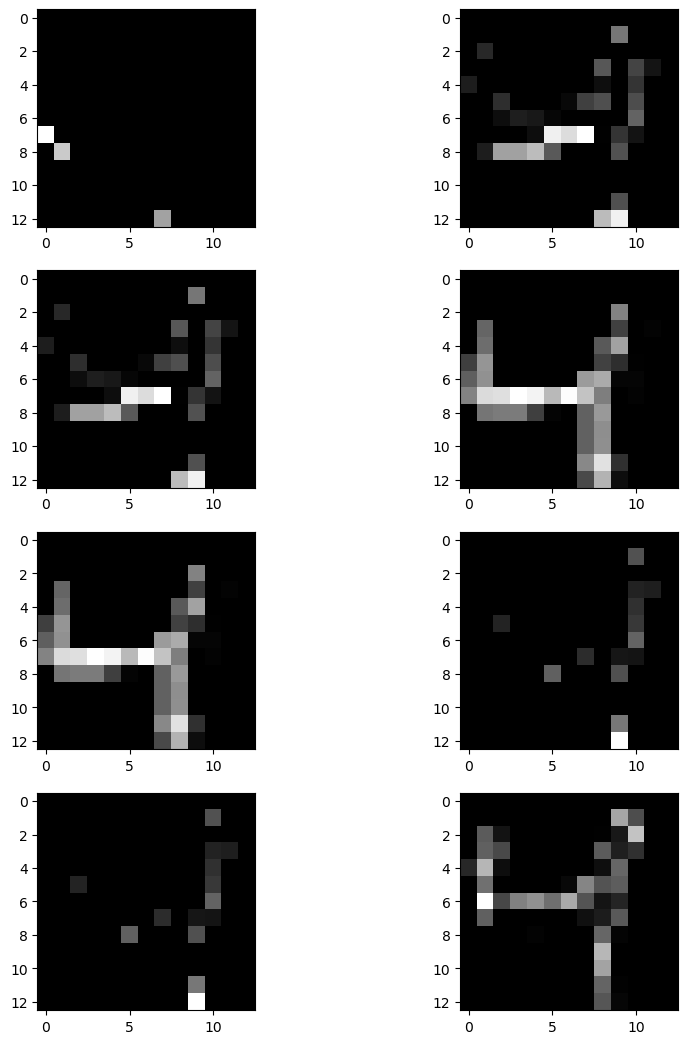

In [54]:
fig, axs = plt.subplots(4, 2, figsize=(10, 13))
for i, ax in enumerate(axs):
    ax[0].imshow(pool_out2[i], cmap='gray')
    ax[1].imshow(pool_out2[i+1], cmap='gray')

In [55]:
d1_out2 = dense.forward(pool_out2)

In [56]:
d1_out2

array([-0.04377275, -0.04111625, -0.04953814, -0.04905753,  0.4089544 ,
       -0.04481231, -0.04364515, -0.04495704, -0.04557312, -0.0436354 ])

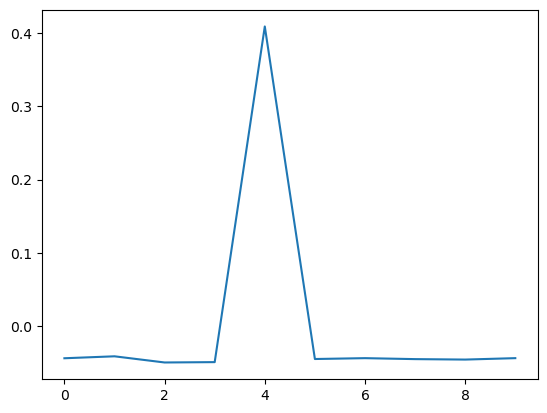

In [57]:
plt.plot(d1_out2)
plt.show()

In [58]:
soft_out2 = softmax(d1_out2)

In [59]:
soft_out2

array([0.09469267, 0.09494456, 0.0941483 , 0.09419356, 0.14891323,
       0.09459429, 0.09470476, 0.0945806 , 0.09452235, 0.09470568])

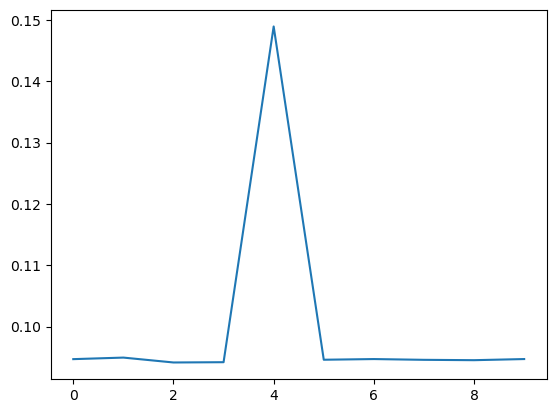

In [60]:
plt.plot(soft_out2)
plt.show()

In [61]:
loss = cross_entropy(soft_out2, output)

In [62]:
loss

1.9043914803269273

In [63]:
gradient2 = soft_out2 - output

In [64]:
gradient2

array([ 0.09469267,  0.09494456,  0.0941483 ,  0.09419356, -0.85108677,
        0.09459429,  0.09470476,  0.0945806 ,  0.09452235,  0.09470568])

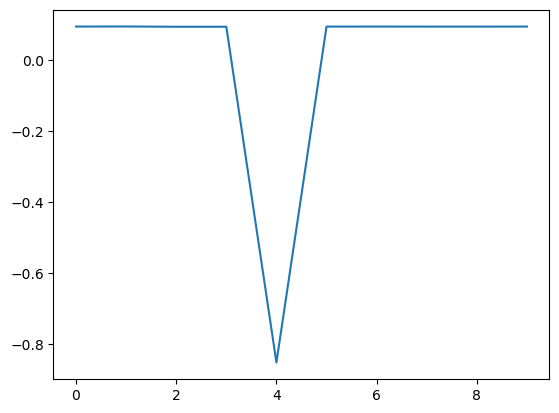

In [65]:
plt.plot(gradient2)
plt.show()

In [66]:
grad_back2 = dense.backward(gradient2, 0.04)

In [67]:
grad_back2.shape

(8, 13, 13)

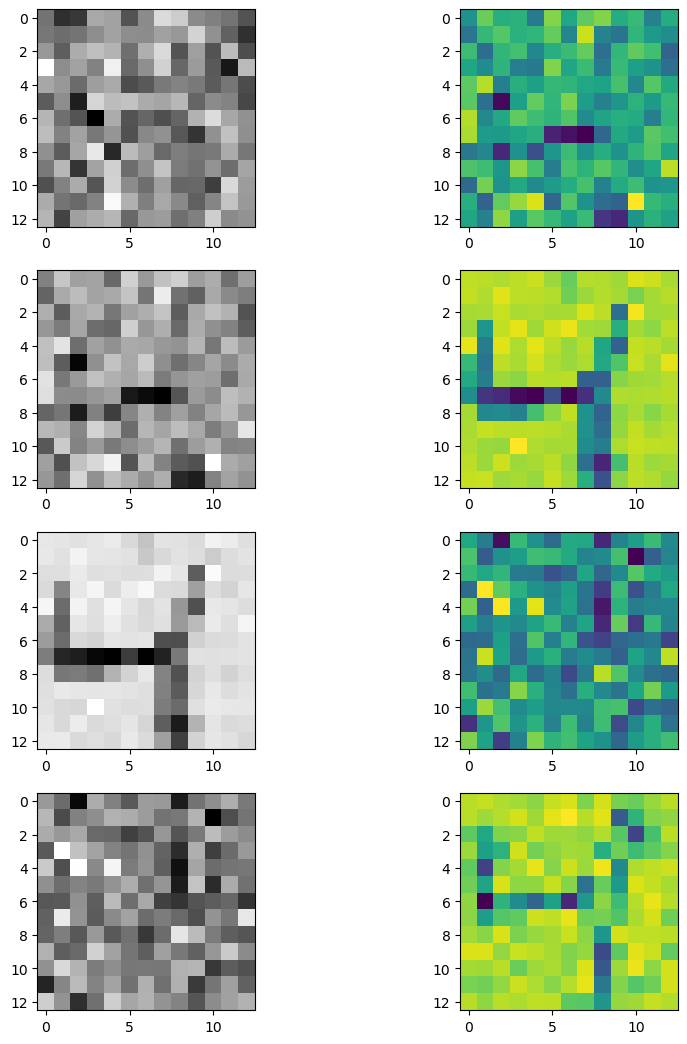

In [68]:
fig, axs = plt.subplots(4, 2, figsize=(10, 13))
for i, ax in enumerate(axs):
    ax[0].imshow(grad_back2[i], cmap="gray")
    ax[1].imshow(grad_back2[i+1])

In [69]:
grad_back2 = pool.backward(grad_back2)

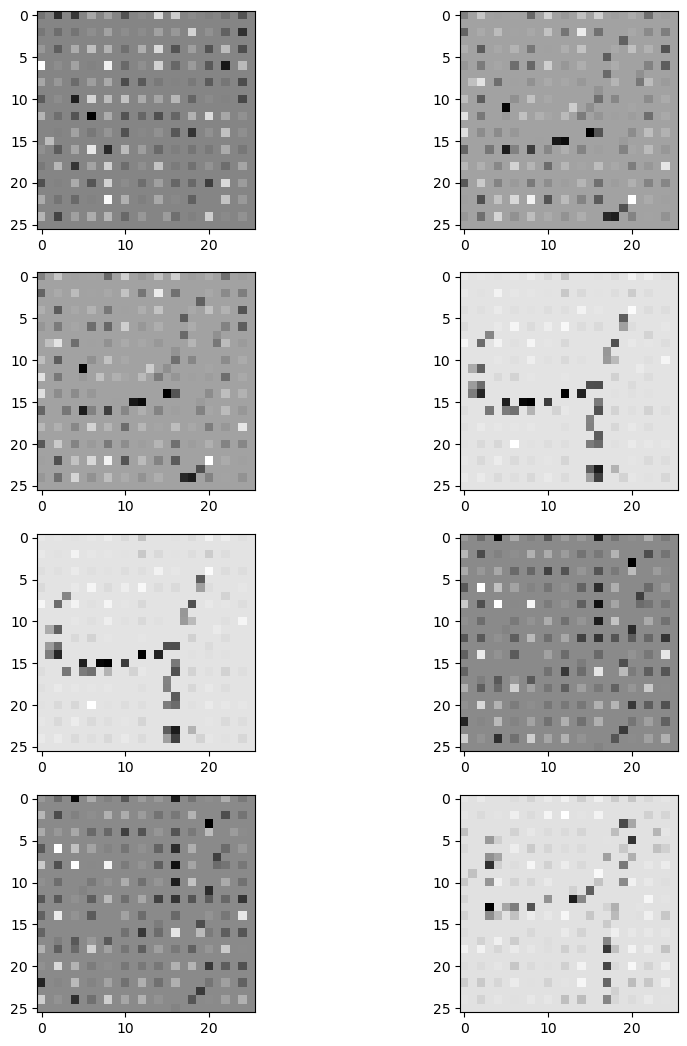

In [70]:
fig, axs = plt.subplots(4, 2, figsize=(10, 13))
for i, ax in enumerate(axs):
    ax[0].imshow(grad_back2[i], cmap="gray")
    ax[1].imshow(grad_back2[i+1],cmap="gray")

In [71]:
grad_back2 = relu.backward(grad_back2)

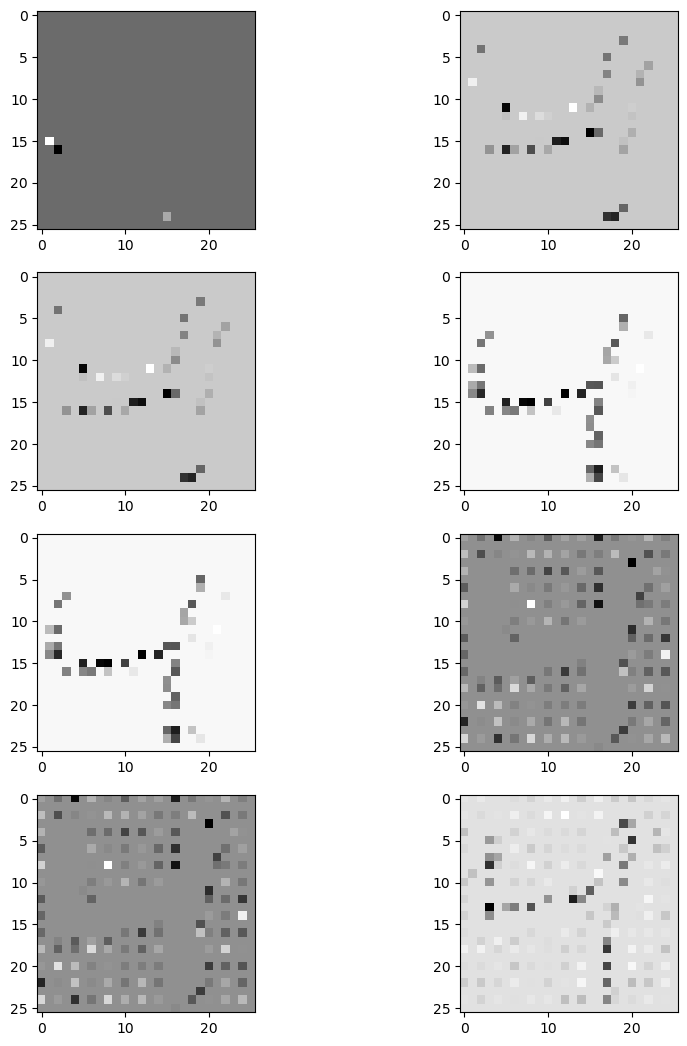

In [72]:
fig, axs = plt.subplots(4, 2, figsize=(10, 13))
for i, ax in enumerate(axs):
    ax[0].imshow(grad_back2[i], cmap="gray")
    ax[1].imshow(grad_back2[i+1],cmap="gray")

In [73]:
conv.backward(grad_back2, 0.04)

In [74]:
prediction(sample_image,output)

-1

In [75]:
out3 = conv.forward(sample_image)

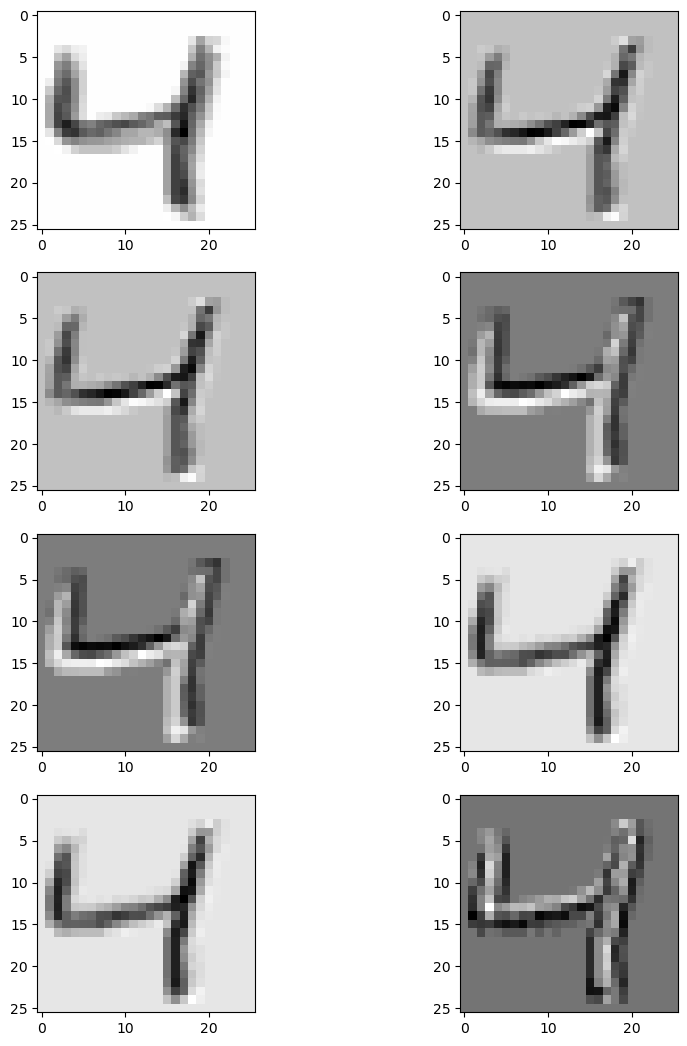

In [76]:
fig, axs = plt.subplots(4, 2, figsize=(10, 13))
for i, ax in enumerate(axs):
    ax[0].imshow(out3[i], cmap="gray")
    ax[1].imshow(out3[i+1], cmap="gray")

In [77]:
relu_out3 = relu.forward(out3)

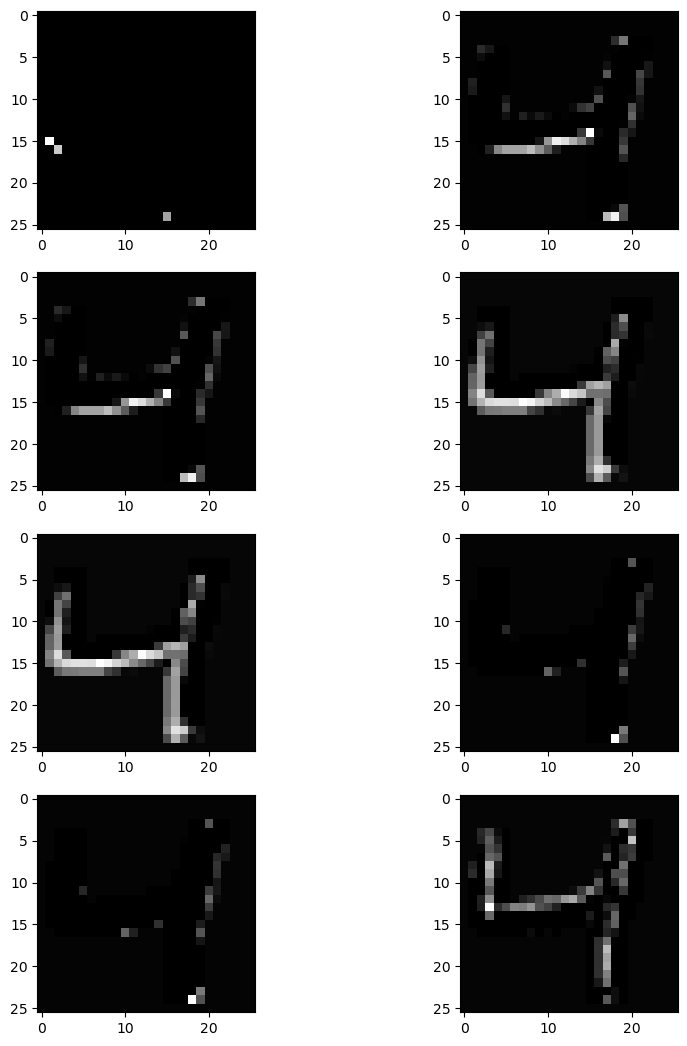

In [78]:
fig, axs = plt.subplots(4, 2, figsize=(10, 13))
for i, ax in enumerate(axs):
    ax[0].imshow(relu_out3[i], cmap="gray")
    ax[1].imshow(relu_out3[i+1], cmap="gray")

In [79]:
pool_out3 = pool.forward(relu_out3)

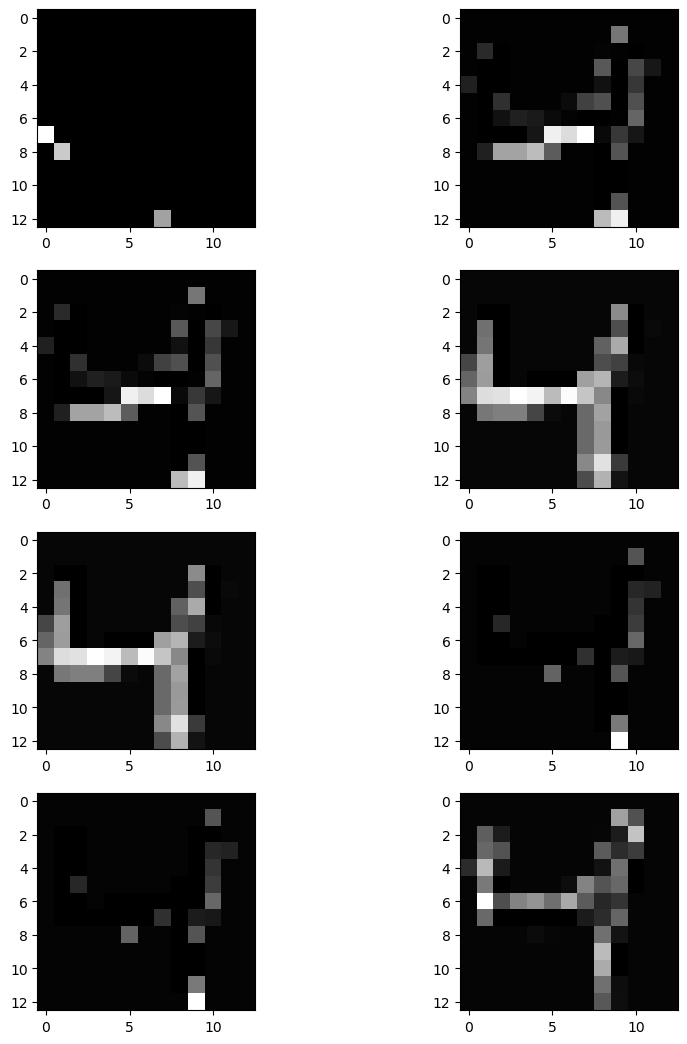

In [80]:
fig, axs = plt.subplots(4, 2, figsize=(10, 13))
for i, ax in enumerate(axs):
    ax[0].imshow(pool_out3[i], cmap="gray")
    ax[1].imshow(pool_out3[i+1], cmap="gray")

In [81]:
d_out3 = dense.forward(pool_out3)

In [82]:
d_out3

array([-0.10070094, -0.0981788 , -0.10756781, -0.10697484,  0.92330882,
       -0.10114393, -0.10101928, -0.10202418, -0.10221509, -0.10029792])

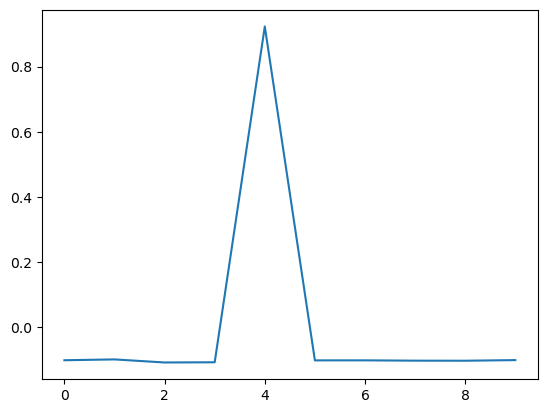

In [83]:
plt.plot(d_out3)
plt.show()

In [84]:
soft_out3 = softmax(d_out3)

In [85]:
soft_out3

array([0.08495764, 0.08517219, 0.08437625, 0.0844263 , 0.23655071,
       0.08492002, 0.0849306 , 0.0848453 , 0.0848291 , 0.08499189])

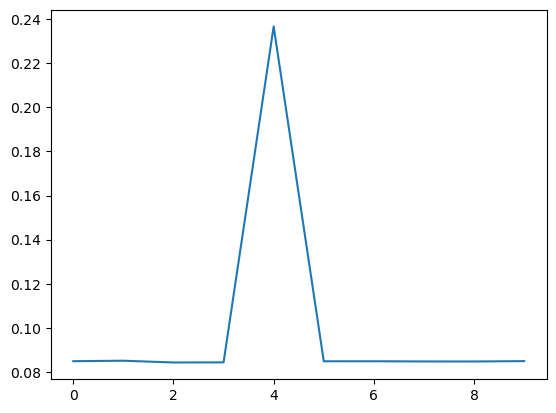

In [86]:
plt.plot(soft_out3)
plt.show()

In [87]:
loss3 = cross_entropy(soft_out3, output)

In [88]:
loss3

1.4415926891828483

In [89]:
gradient3 =  soft_out3- output

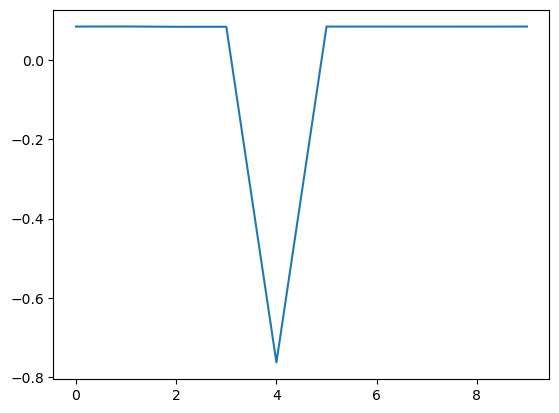

In [90]:
plt.plot(gradient3)
plt.show()

In [91]:
grad_back3 = dense.backward(gradient3, 0.04)

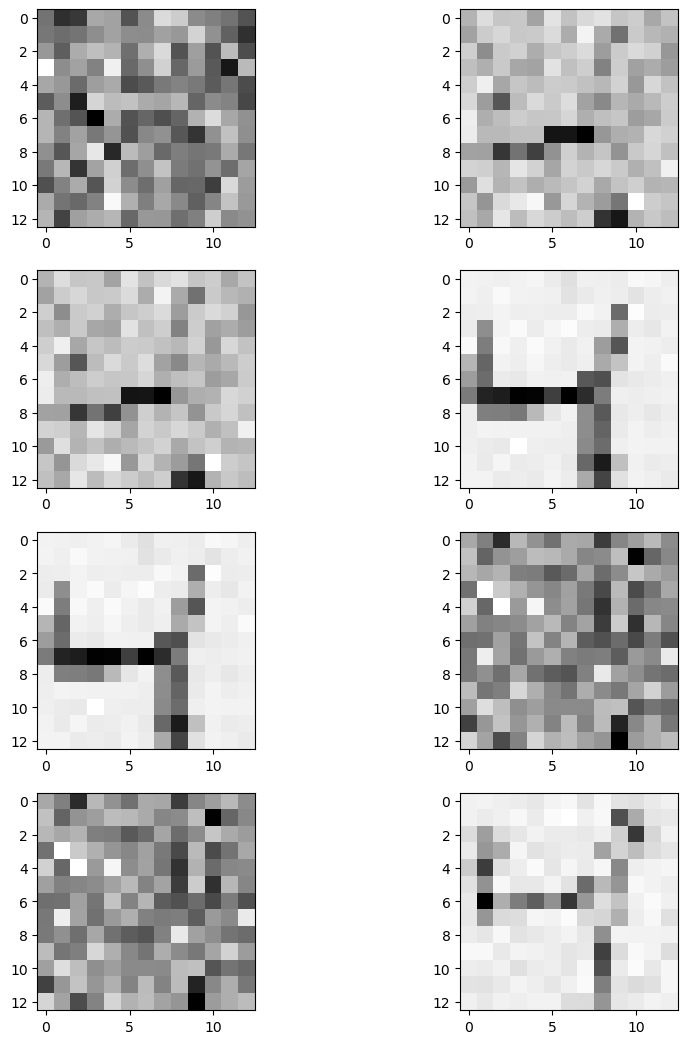

In [92]:
fig, axs = plt.subplots(4, 2, figsize=(10, 13))
for i, ax in enumerate(axs):
    ax[0].imshow(grad_back3[i], cmap="gray")
    ax[1].imshow(grad_back3[i+1], cmap="gray")

In [93]:
grad_back3 = pool.backward(grad_back3)

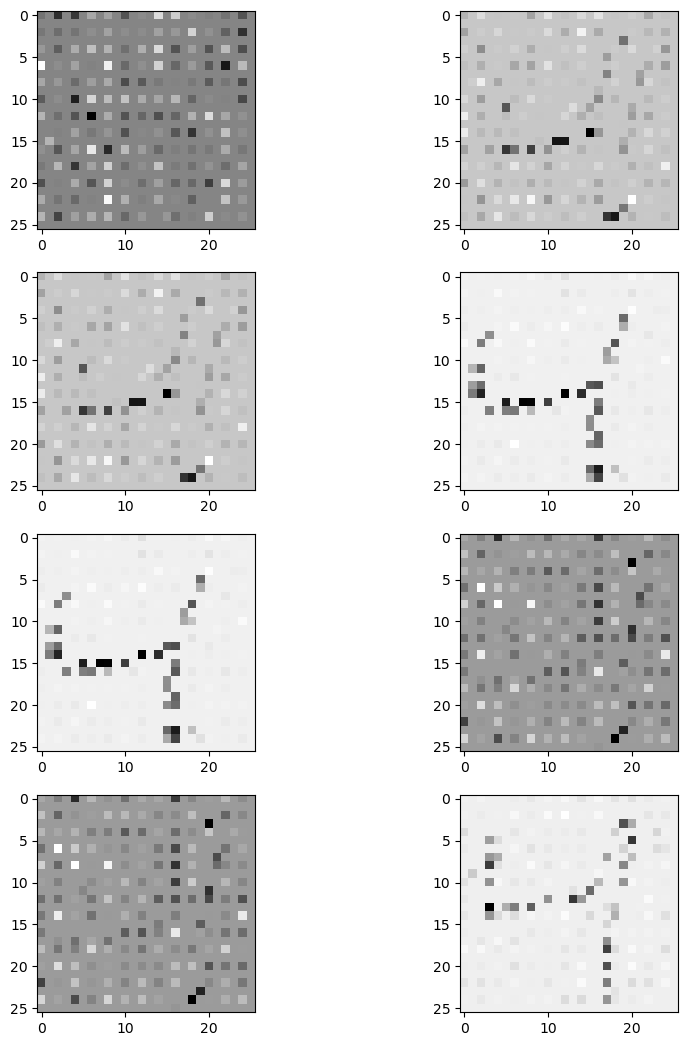

In [94]:
fig, axs = plt.subplots(4, 2, figsize=(10, 13))
for i, ax in enumerate(axs):
    ax[0].imshow(grad_back3[i], cmap="gray")
    ax[1].imshow(grad_back3[i+1], cmap="gray")

In [95]:
grad_back3 = relu.backward(grad_back3)

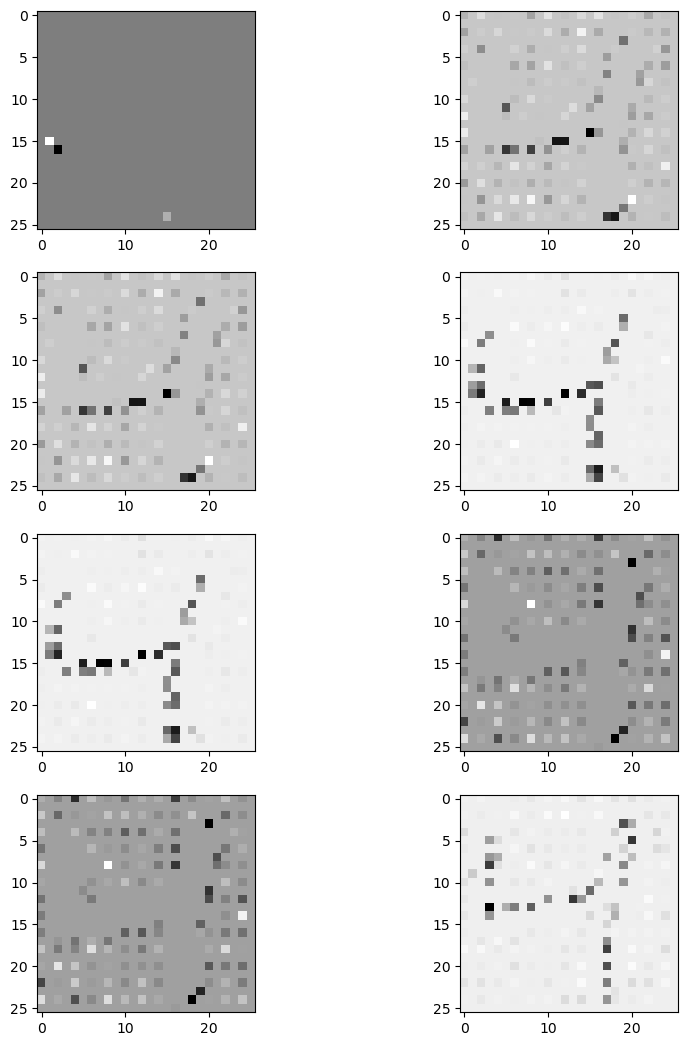

In [96]:
fig, axs = plt.subplots(4, 2, figsize=(10, 13))
for i, ax in enumerate(axs):
    ax[0].imshow(grad_back3[i], cmap="gray")
    ax[1].imshow(grad_back3[i+1], cmap="gray")

In [97]:
conv.backward(grad_back3, 0.04)

In [98]:
prediction(sample_image,output)

-1

In [99]:
out4 = conv.forward(sample_image)

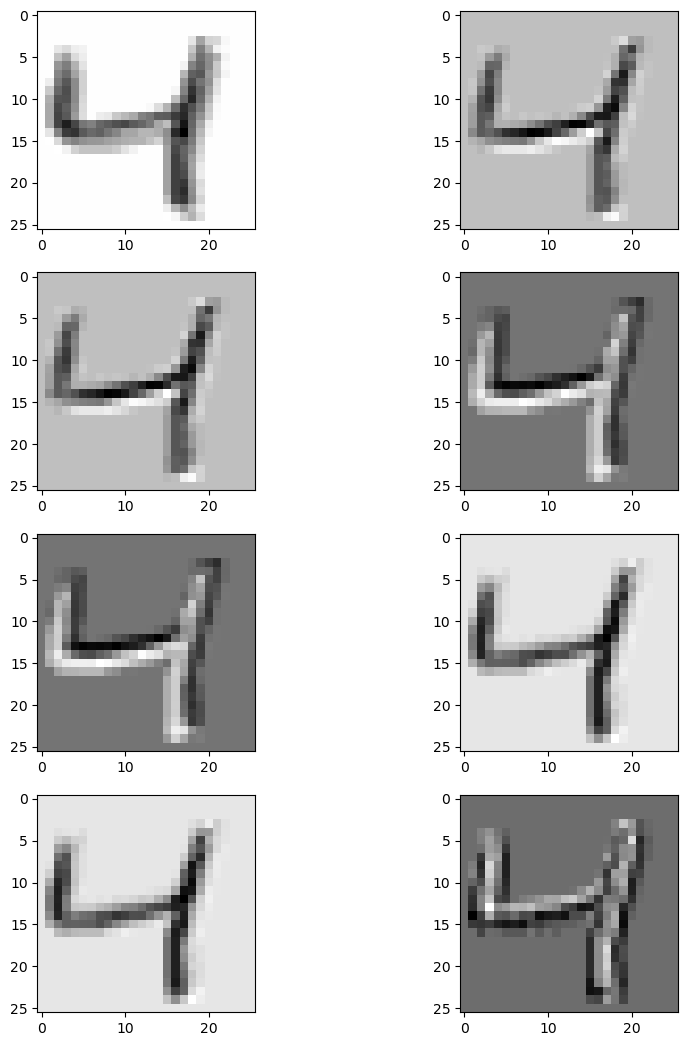

In [100]:
fig,axs=plt.subplots(4,2, figsize=(10,13))
for i, ax in enumerate(axs):
    ax[0].imshow(out4[i], cmap="gray")
    ax[1].imshow(out4[i+1], cmap="gray")

In [101]:
relu_out4 = relu.forward(out4)

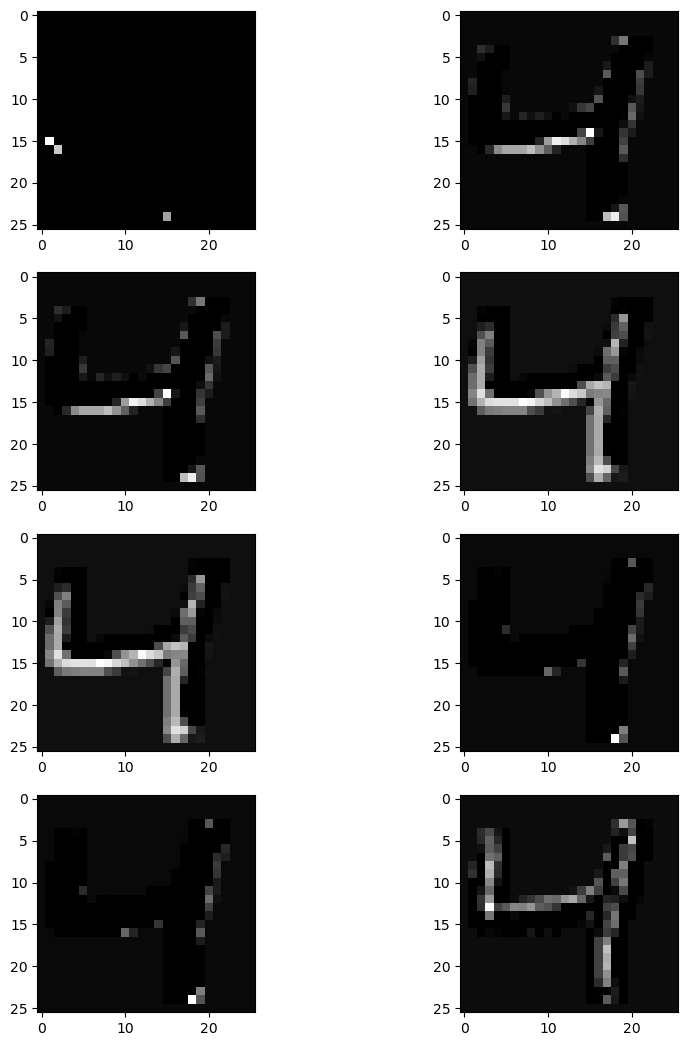

In [102]:
fig,axs=plt.subplots(4,2, figsize=(10,13))
for i, ax in enumerate(axs):
    ax[0].imshow(relu_out4[i], cmap="gray")
    ax[1].imshow(relu_out4[i+1], cmap="gray")

In [103]:
pool_out4 = pool.forward(relu_out4)

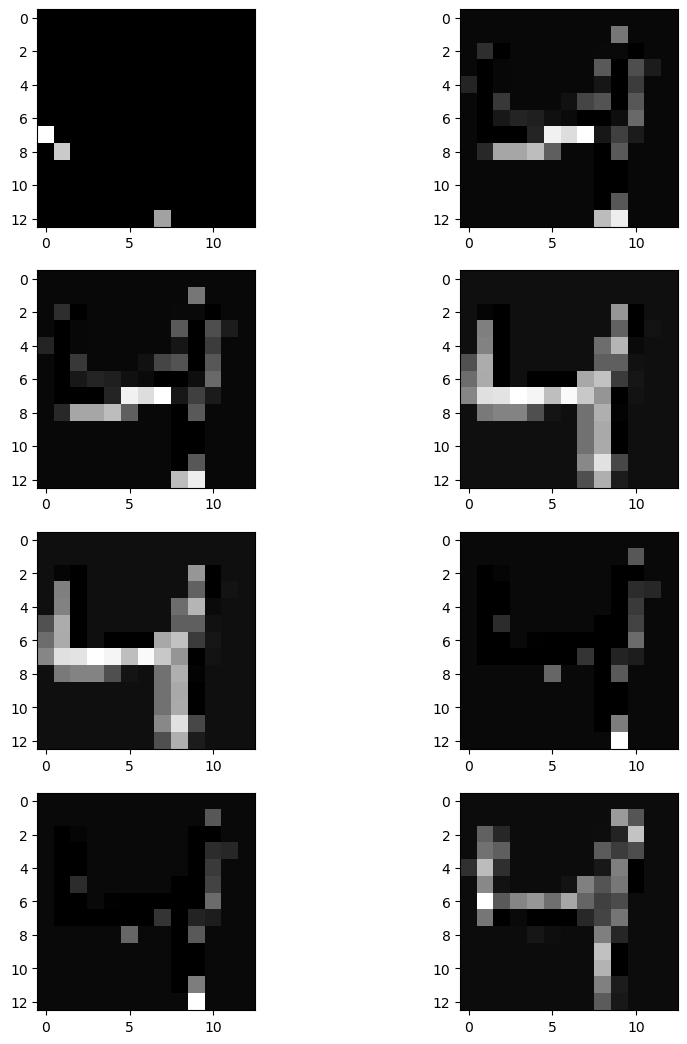

In [104]:
fig,axs=plt.subplots(4,2, figsize=(10,13))
for i, ax in enumerate(axs):
    ax[0].imshow(pool_out4[i], cmap="gray")
    ax[1].imshow(pool_out4[i+1], cmap="gray")

In [105]:
d_out4 = dense.forward(pool_out4)

In [106]:
d_out4

array([-0.19116721, -0.18882265, -0.19990954, -0.19915642,  1.74081606,
       -0.19063399, -0.19217658, -0.19270992, -0.19214062, -0.19030149])

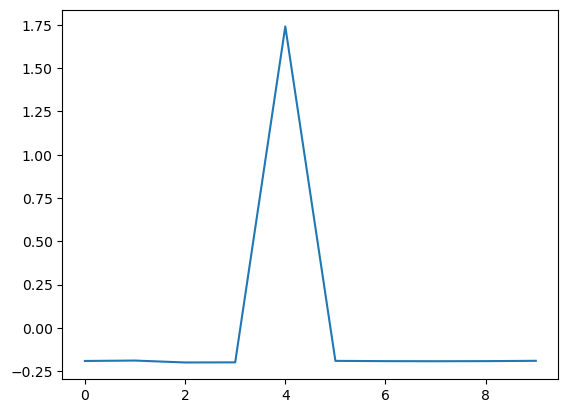

In [107]:
plt.plot(d_out4)
plt.show()

In [108]:
soft_out4 = softmax(d_out4)

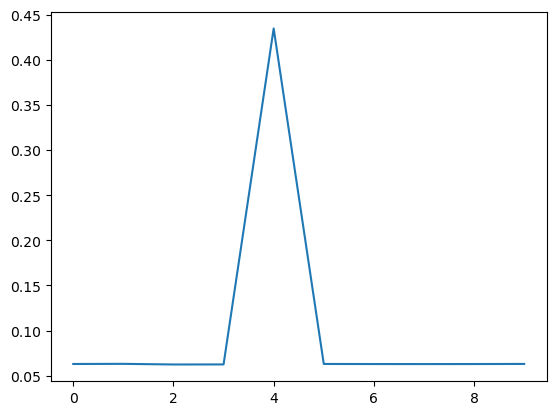

In [109]:
plt.plot(soft_out4)
plt.show()

In [110]:
loss4 = cross_entropy(soft_out4, output)

In [111]:
loss4

0.8335021189011659

In [112]:
gradient4 = soft_out4 - output

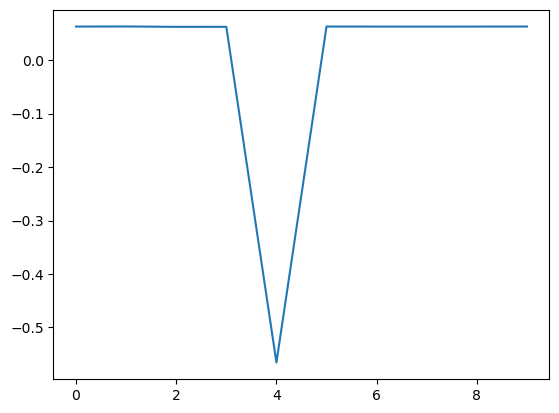

In [113]:
plt.plot(gradient4)
plt.show()

In [114]:
grad_back4 = dense.backward(gradient4, 0.04)

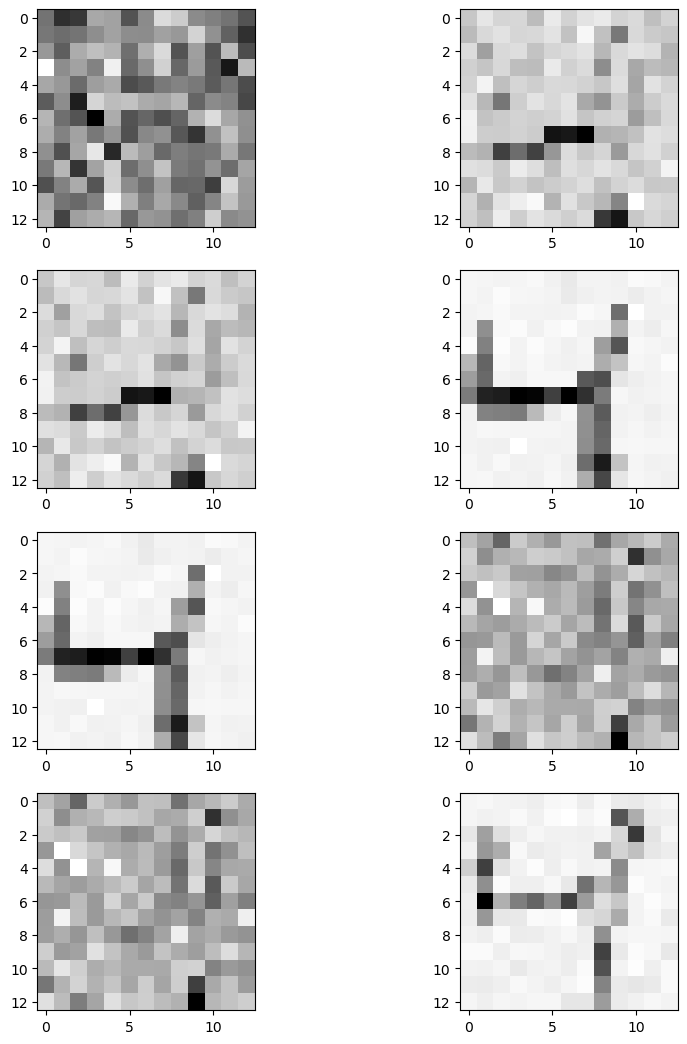

In [115]:
fig,axs=plt.subplots(4,2, figsize=(10,13))
for i, ax in enumerate(axs):
    ax[0].imshow(grad_back4[i], cmap="gray")
    ax[1].imshow(grad_back4[i+1], cmap="gray")

In [116]:
grad_back4 = pool.backward(grad_back4)

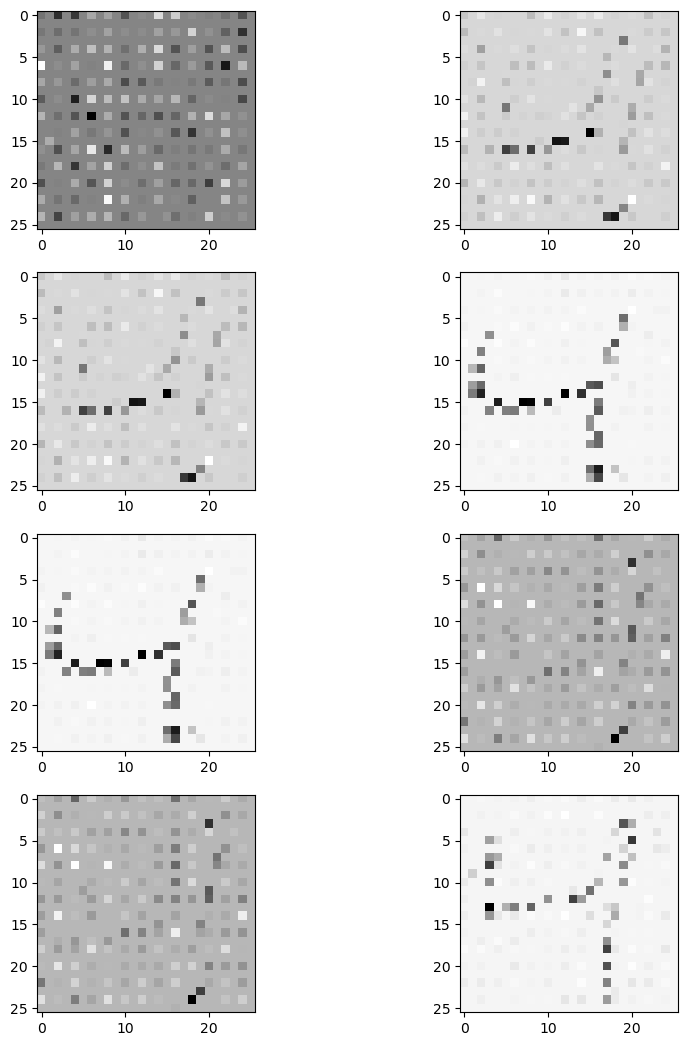

In [117]:
fig,axs=plt.subplots(4,2, figsize=(10,13))
for i, ax in enumerate(axs):
    ax[0].imshow(grad_back4[i], cmap="gray")
    ax[1].imshow(grad_back4[i+1], cmap="gray")

In [118]:
grad_back4 = relu.backward(grad_back4)

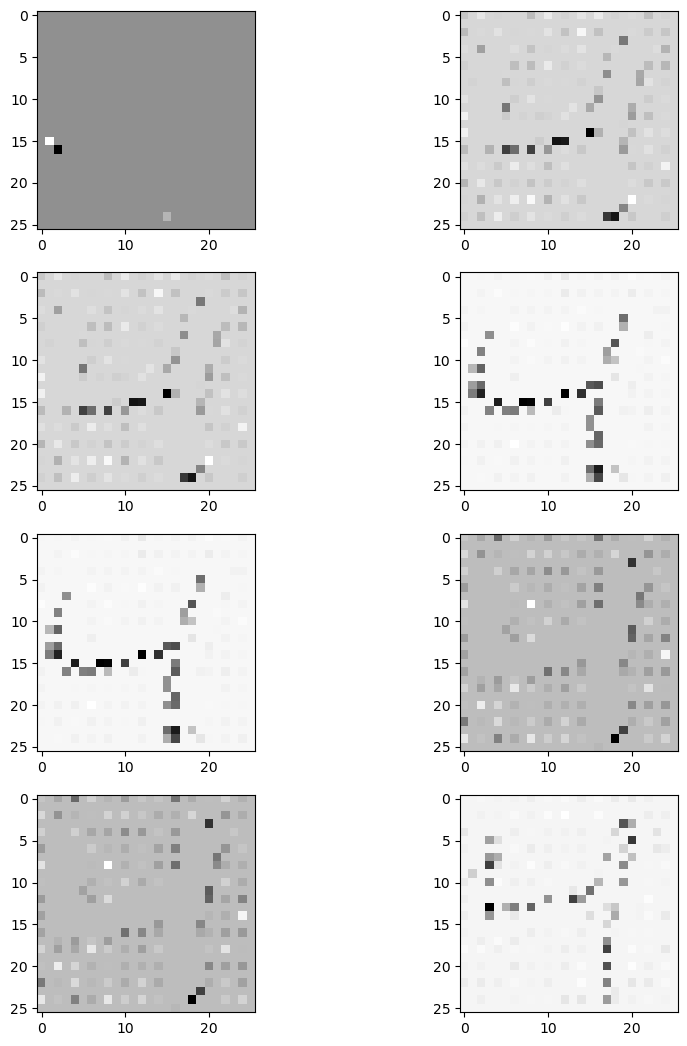

In [119]:
fig,axs=plt.subplots(4,2, figsize=(10,13))
for i, ax in enumerate(axs):
    ax[0].imshow(grad_back4[i], cmap="gray")
    ax[1].imshow(grad_back4[i+1], cmap="gray")

In [120]:
conv.backward(grad_back4, 0.04)

In [121]:
prediction(sample_image,output)

4